In [ ]:
import gymnasium as gym
import numpy as np
import os
import time

import matplotlib.pyplot as plt
from Helper import LearningCurvePlot, smooth
from NDQN import VEC_NDQN
import matplotlib.cm as cm

# Exercise 2.1 - Naive DQN

## Using a vectorized env!

In [69]:
n_eval_episodes = 50
envs = gym.make_vec("CartPole-v1", 1000)
eval_envs = gym.make_vec("CartPole-v1", n_eval_episodes // 2)

In [70]:
test = VEC_NDQN(
    env=envs,
    eval_env=eval_envs,
    eval_time=5 * envs.num_envs,
    epsilon=0.1,
    gamma=0.9,
    learning_rate=1e-4,
    network_size=64,
)

In [71]:
test.agent.summary()

Model: "sequential_211"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_633 (Dense)               │ (None, 128)            │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_634 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_635 (Dense)               │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,026 (35.26 KB)

 Trainable params: 9,026 (35.26 KB)

 Non-trainable params: 0 (0.00 B)

In [72]:
test.train_agent()

Step 1000/1000001, average reward of evaluated episodes: 9.366666666666667 +- 0.6046119049072349
Step 5000/1000001, average reward of evaluated episodes: 9.133333333333333 +- 0.7630348761506397
Step 10000/1000001, average reward of evaluated episodes: 9.6 +- 0.7118052168020874
Step 15000/1000001, average reward of evaluated episodes: 8.933333333333334 +- 0.8537498983243799
Step 20000/1000001, average reward of evaluated episodes: 9.266666666666667 +- 0.6289320754704403
Step 25000/1000001, average reward of evaluated episodes: 9.266666666666667 +- 0.6798692684790381
Step 30000/1000001, average reward of evaluated episodes: 9.133333333333333 +- 0.7180219742846005
Step 35000/1000001, average reward of evaluated episodes: 9.366666666666667 +- 0.752034278178565
Step 40000/1000001, average reward of evaluated episodes: 9.166666666666666 +- 0.6871842709362768
Step 45000/1000001, average reward of evaluated episodes: 9.2 +- 0.8717797887081347
Step 50000/1000001, average reward of evaluated epi

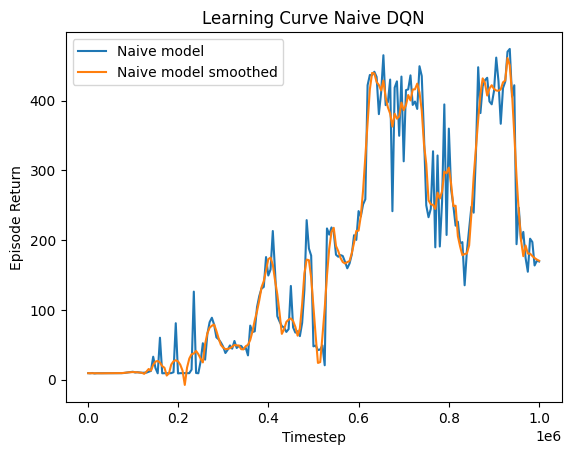

In [73]:
LCTest = LearningCurvePlot(title="Learning Curve Naive DQN")
LCTest.add_curve(test.eval_timesteps, test.eval_returns, label='Naive model')
LCTest.add_curve(test.eval_timesteps, smooth(test.eval_returns,window=9),label='Naive model smoothed')
LCTest.ax.legend()

In [77]:
def average_over_repetitions(
    n_repetitions,
    agent,
):
    returns_over_repetitions = []

    for rep in range(n_repetitions):  # Loop over repetitions
        print(f"Starting iteration {rep+1}")
        now = time.time()

        # Reset agent
        agent.reset_weights()
        
        # Train using reset weights
        agent.train_agent()

        # Obtain returns and timesteps
        returns, timesteps = agent.eval_returns, agent.eval_timesteps
        returns_over_repetitions.append(returns)

        print("Running one rep takes {} minutes".format((time.time() - now) / 60))

    learning_curve = np.mean(
        np.array(returns_over_repetitions), axis=0
    )  # average over repetitions
    
    return learning_curve, returns_over_repetitions, timesteps

Run for 5 repetitions

In [ ]:
n_eval_episodes = 50
envs = gym.make_vec("CartPole-v1", 5000)
eval_envs = gym.make_vec("CartPole-v1", n_eval_episodes // 2)

NDQN = VEC_NDQN(
    env=envs,
    eval_env=eval_envs,
    eval_time=5000,
    epsilon=0.1,
    gamma=0.9,
    learning_rate=1e-4,
    network_size=64,
)

# Start learning
NDQN_learning_curve, NDQN_returns, NDQN_timesteps = average_over_repetitions(5, NDQN)

Starting iteration 1
Running one rep takes 4.49600434700648 minutes
Starting iteration 2
Running one rep takes 4.824237287044525 minutes
Starting iteration 3
Running one rep takes 4.2606958746910095 minutes
Starting iteration 4
Running one rep takes 5.034952131907145 minutes
Starting iteration 5
Running one rep takes 5.512892607847849 minutes


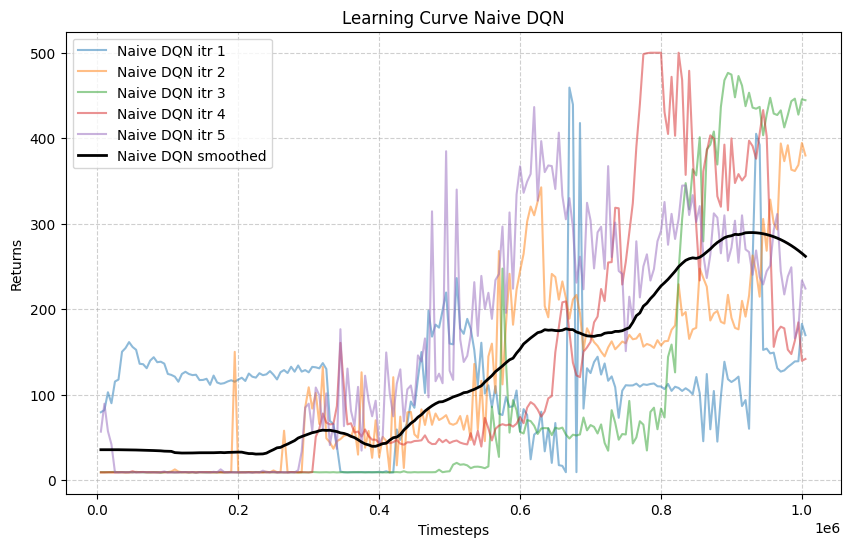

In [ ]:
# Plot results using matplotlib
plt.figure(figsize=(10, 6))
for it in range(len(NDQN_returns)):
    plt.plot(NDQN_timesteps, NDQN_returns[it], label=f'Naive DQN itr {it+1}', alpha=0.5)
plt.plot(NDQN_timesteps, smooth(NDQN_learning_curve, window=9), label='Naive DQN smoothed', linewidth=2, color='black')
plt.xlabel('Timesteps')
plt.ylabel('Returns')
plt.title('Learning Curve Naive DQN')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# 2.2 ablation study of hyperparameters
* Do: 
    * Learning rate 
    * Update-to-data ratio (how many env steps per update)
    * Network size
    * Epsilon
* For each do atleast a test for 3 values: small, medium and large/high.

In [82]:
def hyperparameter_study(
    learning_rates=[1e-5, 1e-3, 0.1],
    epsilons=[0.05, 0.1, 0.5],
    network_sizes=[32, 64, 128],
    update_to_data_ratio=[0.1, 0.5, 1.0],
):
    n_eval_episodes = 50
    envs = gym.make_vec("CartPole-v1", 5000)
    eval_envs = gym.make_vec("CartPole-v1", n_eval_episodes // 2)

    for update_ratio in update_to_data_ratio:
        for learning_rate in learning_rates:
            for epsilon in epsilons:
                for network_size in network_sizes:
                    # Check if this set of hyperparameters has already been stored to a file, if yes, skip it
                    filename = f"NDQN_data_update_ratio{update_ratio}_lr{learning_rate}_eps{epsilon}_nwsize{network_size}.npz"
                    if os.path.exists(filename):
                        print(f"Skipping {filename}, already exists.")
                        continue

                    print(f"Testing update ratio {update_ratio} - lr {learning_rate} - eps {epsilon} - network size {network_size}")
                    NDQN = VEC_NDQN(
                        env=envs,
                        eval_env=eval_envs,
                        eval_time=5000,
                        epsilon=epsilon,
                        gamma=0.9,
                        learning_rate=learning_rate,
                        network_size=network_size,
                        update_to_data_ratio=update_ratio,
                    )

                    # Start learning
                    NDQN_learning_curve, NDQN_returns, NDQN_timesteps = (
                        average_over_repetitions(5, NDQN)
                    )

                    # Store results
                    np.savez(
                        filename,
                        learning_curve=NDQN_learning_curve,
                        returns_over_repetitions=NDQN_returns,
                        timesteps=NDQN_timesteps,
                    )

In [83]:
hyperparameter_study()

Testing update ratio 0.1 - lr 1e-05 - eps 0.05 - network size 32
Starting iteration 1
Running one rep takes 3.7047345360120136 minutes
Starting iteration 2
Running one rep takes 1.173492475350698 minutes
Starting iteration 3
Running one rep takes 1.236207095781962 minutes
Starting iteration 4
Running one rep takes 1.2254462083180746 minutes
Starting iteration 5
Running one rep takes 1.2334769248962403 minutes
Testing update ratio 0.1 - lr 1e-05 - eps 0.05 - network size 64
Starting iteration 1
Running one rep takes 1.2641119639078775 minutes
Starting iteration 2
Running one rep takes 1.2564465562502543 minutes
Starting iteration 3
Running one rep takes 1.2507511178652446 minutes
Starting iteration 4
Running one rep takes 1.25094895362854 minutes
Starting iteration 5
Running one rep takes 1.2324073513348897 minutes
Testing update ratio 0.1 - lr 1e-05 - eps 0.05 - network size 128
Starting iteration 1
Running one rep takes 1.231803798675537 minutes
Starting iteration 2
Running one rep ta

KeyboardInterrupt: 

Create plotting scheme for various combinations of hyperparameters

Loaded in 81 files out of 81


C:\Users\colin\AppData\Local\Temp\ipykernel_15892\3370564277.py:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("viridis", len(param_values))


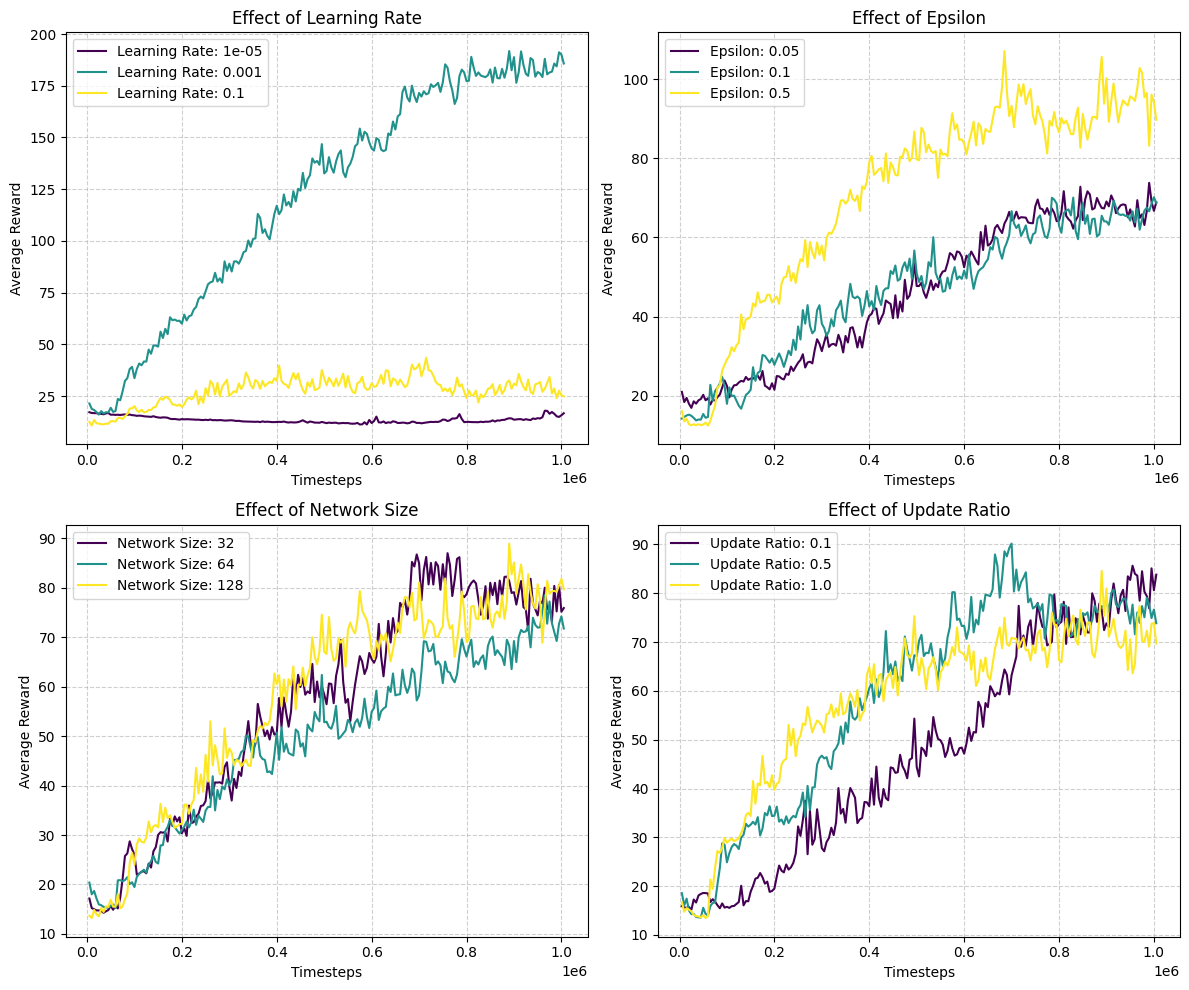

In [85]:
def load_data(learning_rates, epsilons, network_sizes, update_to_data_ratio):
    data_dict = {
        "lr": {lr: [] for lr in learning_rates},
        "eps": {eps: [] for eps in epsilons},
        "nwsize": {nw: [] for nw in network_sizes},
        "ur": {ur: [] for ur in update_to_data_ratio},
    }
    
    count = 0
    for learning_rate in learning_rates:
        for epsilon in epsilons:
            for network_size in network_sizes:
                for update_ratio in update_to_data_ratio:
                    filename = f"NDQN_data_update_ratio{update_ratio}_lr{learning_rate}_eps{epsilon}_nwsize{network_size}.npz"
                    
                    if os.path.exists(filename):
                        count +=1
                        data = np.load(filename)
                        curve, timesteps = data["learning_curve"], data["timesteps"]
                        final_reward = curve[-1]
                        
                        # Store by fixed hyperparameter
                        data_dict["lr"][learning_rate].append((timesteps, curve))
                        data_dict["eps"][epsilon].append((timesteps, curve))
                        data_dict["nwsize"][network_size].append((timesteps, curve))
                        data_dict["ur"][update_ratio].append((timesteps, curve))
    print(f"Loaded in {count} files out of {3**4}")
    return data_dict

def plot_mean_learning_curves(data_dict):
    hyperparams = ["lr", "eps", "nwsize", "ur"]
    titles = {
        "lr": "Learning Rate",
        "eps": "Epsilon",
        "nwsize": "Network Size",
        "ur": "Update Ratio"
    }
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()
    
    for ax, key in zip(axes, hyperparams):
        param_values = sorted(data_dict[key].keys())
        cmap = cm.get_cmap("viridis", len(param_values))
        
        for i, value in enumerate(param_values):
            curves = data_dict[key][value]
            if curves:
                max_timesteps = max(len(t[1]) for t in curves)
                mean_curve = np.zeros(max_timesteps)
                count = np.zeros(max_timesteps)
                
                for timesteps, curve in curves:
                    length = len(curve)
                    mean_curve[:length] += curve
                    count[:length] += 1
                
                mean_curve /= np.where(count == 0, 1, count)
                ax.plot(timesteps, mean_curve, label=f"{titles[key]}: {value}", color=cmap(i))
        
        ax.set_title(f"Effect of {titles[key]}")
        ax.set_xlabel("Timesteps")
        ax.set_ylabel("Average Reward")
        ax.grid(True, linestyle="--", alpha=0.6)
        ax.legend()
    
    plt.tight_layout()
    plt.show()

def plot_hyperparameter_aggregated_curves():
    learning_rates = [1e-5, 1e-3, 0.1]
    epsilons = [0.05, 0.1, 0.5]
    network_sizes = [32, 64, 128]
    update_to_data_ratio = [0.1, 0.5, 1.0]
    
    data_dict = load_data(learning_rates, epsilons, network_sizes, update_to_data_ratio)
    plot_mean_learning_curves(data_dict)

plot_hyperparameter_aggregated_curves()